Today we're going to think through how to estimate the number of fish in a lake. This kind of problem is faced regularly to [ecologists](https://en.wikipedia.org/wiki/Mark_and_recapture) trying to estimate population sizes. It will give us a great tour of the fundamentals. Lets get started.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
# Data collection
total_tagged = 68
caught = 219
tagged = 16

### What proportion of fish are tagged?

At first this question sounds easy, its just $\frac{16}{219} = 0.073$ right? The question becomes more interesting when you consider the amount of undertainty around that estimate. We care about the amount of uncertainty because it may influence us to gather more data by going out and tagging catching, and releasing again.

To get a more holistic answer to this question, lets start model building. We'll consider each caught fish as a bernoulli trial where a success is whether or not it was tagged. We'll use flat prior for the proportion of tagged fish, $p$.

$$
\begin{align}
is\_tagged_i &\sim Bernoulli(p_i) \\
p_i &\sim Beta(1, 1)
\end{align}
$$

We can aggregate up bernoulli trials into a binomial to take advantage of beta-binomial conjugacy. 

$$
\begin{align}
tagged &\sim Binomial(caught, p) \\
p &\sim Beta(1, 1)
\end{align}
$$

Conjugacy happens when the posterior distribution can be solved for by hand without having to rely on fancy sampling a la Stan or PyMC3.

$$
\begin{align}
Posterior &= Prior * Likelihood \\
Pr(p | d) &= Pr(p) * Pr(d | p) \\
Pr(p | d) &= Beta(\alpha, \beta) * Binomial(n, k) \\
Pr(p | d) &= Beta(\alpha + k, n - k + \beta)
\end{align}
$$

Armed with this knowledge, we draw 1000 posterior samples in the code below. Then we take our posterior and calculate the mean and 95% credible interval about it.


In [66]:
"""
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """
    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """
    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))

In [103]:
N = 1000
posterior = stats.beta.rvs(a=1+tagged, b=1+(caught-tagged), size=N)
m = round(np.mean(posterior), 3)
ci = hpd(posterior).round(3)

s = f"The proportion of tagged fish is approximately {m} with 95% credibile mass within {ci[0]} and {ci[1]}."
print(s)

The proportion of tagged fish is approximately 0.076 with 95% credibile mass within 0.042 and 0.112.


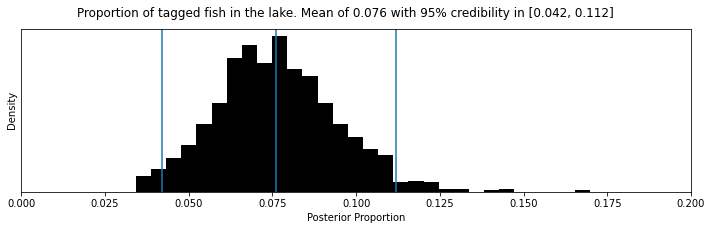

In [118]:
fig, ax = plt.subplots(figsize = (12, 3))
ax.hist(posterior, bins = 30, color = "black")
ax.axvline(ci[0])
ax.axvline(ci[1])
ax.axvline(m)
ax.set_xlim([0, .2])
ax.set_xlabel("Posterior Proportion")
ax.set_yticks([])
ax.set_ylabel("Density")
plt.suptitle(f"Proportion of tagged fish in the lake. Mean of {m} with 95% credibility in [{ci[0]}, {ci[1]}]")
plt.show()

### How many fish are in the lake

Now that we know the proportion of tagged fish it should be easy to calculate the total number of fish. This is because:

$$
\begin{align}
\frac{tagged}{caught} &= \frac{total\_marked}{total\_fish} \\
total\_fish &= \frac{total\_marked}{\frac{tagged}{caught}}
\end{align}
$$

That term in the bottom right is the proportion we calculated earlier. Because we have the full posterior for that term we can just push it on through the calculation to propagate our uncertainty forward.


In [124]:
post_total = total_tagged/posterior

m = round(np.mean(post_total), 1)
ci = hpd(post_total).round(1)

s = f"The number of fish the lake is {m} with 95% credibile mass within {ci[0]} and {ci[1]}."
print(s)


The number of fish the lake is 943.9 with 95% credibile mass within 552.6 and 1455.7.


Lets graph our uncertainty just like before.

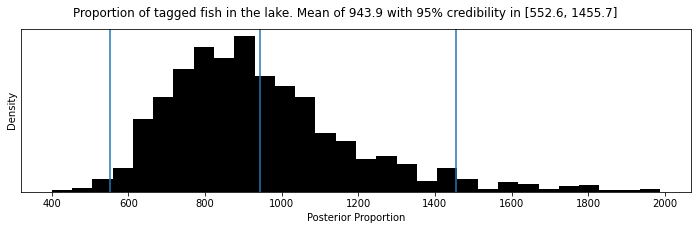

In [127]:
fig, ax = plt.subplots(figsize = (12, 3))
ax.hist(post_total, bins = 30, color = "black")
ax.axvline(ci[0])
ax.axvline(ci[1])
ax.axvline(m)
ax.set_xlabel("Posterior Proportion")
ax.set_yticks([])
ax.set_ylabel("Density")
plt.suptitle(f"Proportion of tagged fish in the lake. Mean of {m} with 95% credibility in [{ci[0]}, {ci[1]}]")
plt.show()

And there we have it. With this distribution we can make future informed decisions based on the health of the lake. We can also gather more data to get more certainty about our measurment.
